In [26]:
import cvm_inference
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cv2

### Instance inference object

In [3]:
inference = cvm_inference.CVMInference()

VGG16: trainable = False
VGG16: trainable = False
Siamese_FC: dim_reduction  trainable = False
CVMInference object created


### Load Aerial Descriptors

In [4]:
filename = 'sat_descriptors.npz'
if os.path.isfile(filename):
    sat_descriptors = np.load(filename)['arr_0']
    print(sat_descriptors.shape)
    print ("Found aerial descriptors file")
else:
    print ("No aerial descriptors file was found... Matching won't be possible")

(5, 4096)
Found aerial descriptors file


### Load satellite and ground images

In [45]:
ground_images = inference.load_images_raw(is_ground = True)
satellite_images = inference.load_images_raw(is_ground = False)

../Data/CVUSA/imgs/aerial0.jpg
../Data/CVUSA/imgs/aerial1.jpg
../Data/CVUSA/imgs/aerial2.jpg
../Data/CVUSA/imgs/aerial3.jpg
../Data/CVUSA/imgs/aerial4.jpg


## Show images

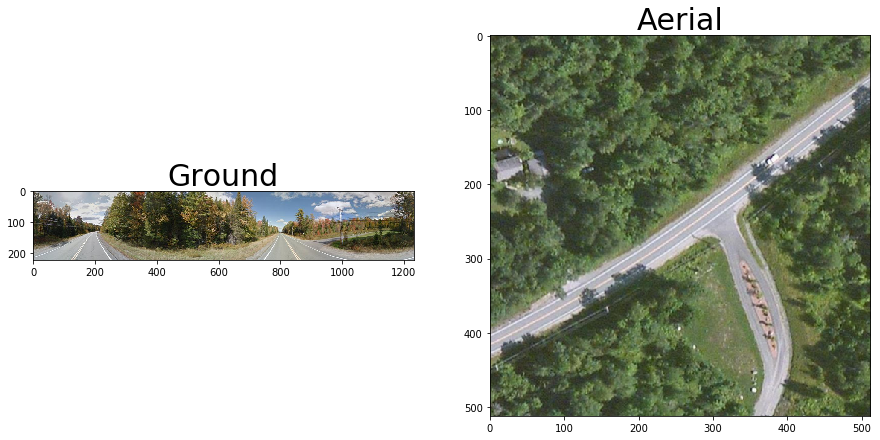

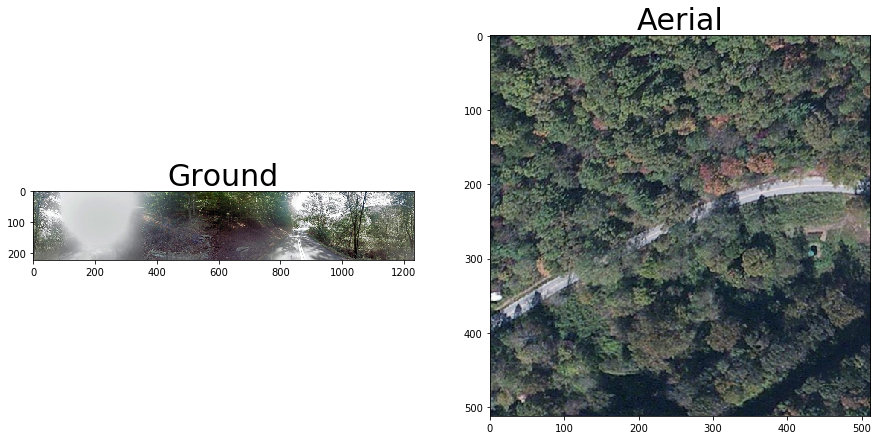

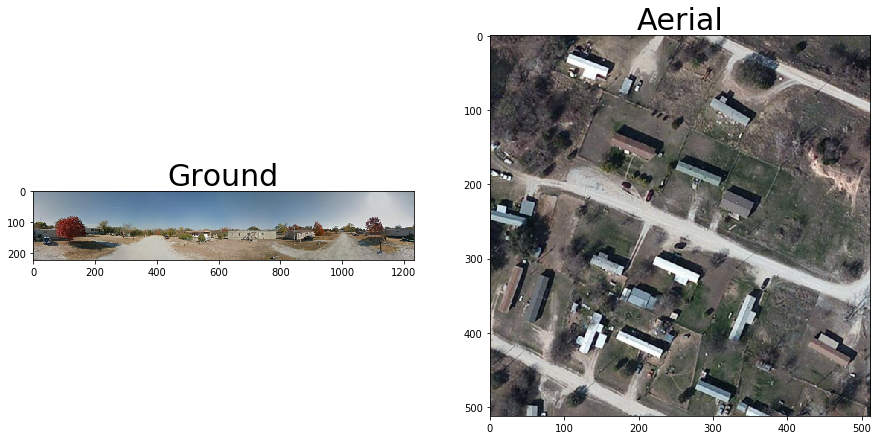

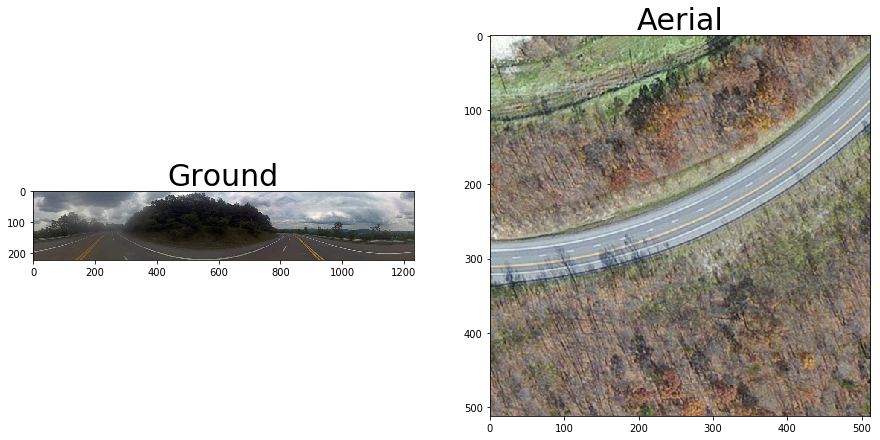

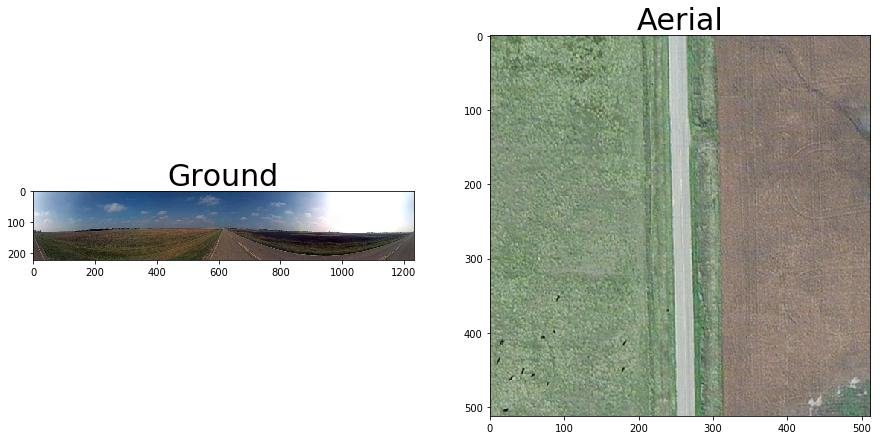

In [46]:
for i in range(5):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(ground_images[i])
    ax1.set_title('Ground', fontsize=30)
    ax2.imshow(satellite_images[i])
    ax2.set_title('Aerial', fontsize=30)
    plt.show()

### Compute descriptors of one of the ground images

In [52]:
ground_img_idx = 0
print("Extracting Descriptors from ground image, this might take some time...")
load_from_file = True
grd_filename = 'ground_descriptors.npz'
if load_from_file:
    if os.path.isfile(filename):
        ground_descriptors = np.load(grd_filename)['arr_0']
        print(ground_descriptors.shape)
        print ("Found ground descriptors file")
    else:
        print ("No ground descriptors file was found... Try setting load_from_file to False to generate it")
else:    
    ground_descriptors = inference.forward(inference.load_images(is_ground = True), is_ground = True)
    np.savez(grd_filename, ground_descriptors)
    print(ground_descriptors.shape)
    


Extracting Descriptors from ground image, this might take some time...
(5, 4096)
Found ground descriptors file


### Find the best matches for the ground image based on the descriptor

In [53]:
# Softmax Function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [54]:
euclidean_distances_list = []
for ground_descriptor in ground_descriptors:
    euclidian_distances = []
    for sat_descriptor in sat_descriptors:
        dist = np.linalg.norm(sat_descriptor-ground_descriptor)
        euclidian_distances.append(1/dist)
    indexes = np.arange(sat_descriptors.shape[0])
    distances_dict = dict(zip(indexes.T, softmax(euclidian_distances)))
    sorted_distances_dict = sorted(distances_dict.items(), key = lambda x:-x[1])
    sorted_distances_dict
    euclidean_distances_list.append(sorted_distances_dict)

In [55]:
print(euclidean_distances_list)

[[(0, 0.5297500168524268), (3, 0.15131192494300794), (1, 0.1075908087083416), (2, 0.10675239585334427), (4, 0.10459485364287936)], [(1, 0.5407567837774063), (3, 0.12404760077054364), (2, 0.1147519027520522), (4, 0.1146259819766566), (0, 0.10581773072334139)], [(2, 0.4676820267285123), (1, 0.1410954792371763), (4, 0.1336747873516098), (0, 0.13034000044487742), (3, 0.12720770623782424)], [(3, 0.3417789922906151), (0, 0.2082587322859034), (1, 0.16267445464784686), (2, 0.14662684334142634), (4, 0.1406609774342083)], [(4, 0.5612452711463392), (1, 0.11780291290692786), (2, 0.11090652164349273), (3, 0.10651903941668471), (0, 0.10352625488655554)]]


### Function to add green frame to ground truth

In [56]:
def add_frame(image, is_ground_truth = True):
    if not is_ground_truth:
        return image
    img = image.copy()
    b = 8
    c=(0,255,0)
    thickness = 10
    width, height, _ = img.shape
    p1 = (b , b)
    p2 = (b , height - b)
    p3 = (width - b , height - b)
    p4 = (width - b , b)
    cv2.line(img, p1, p2, c, thickness)
    cv2.line(img, p2, p3, c, thickness)
    cv2.line(img, p3, p4, c, thickness)
    cv2.line(img, p4, p1, c, thickness)
    return img
    


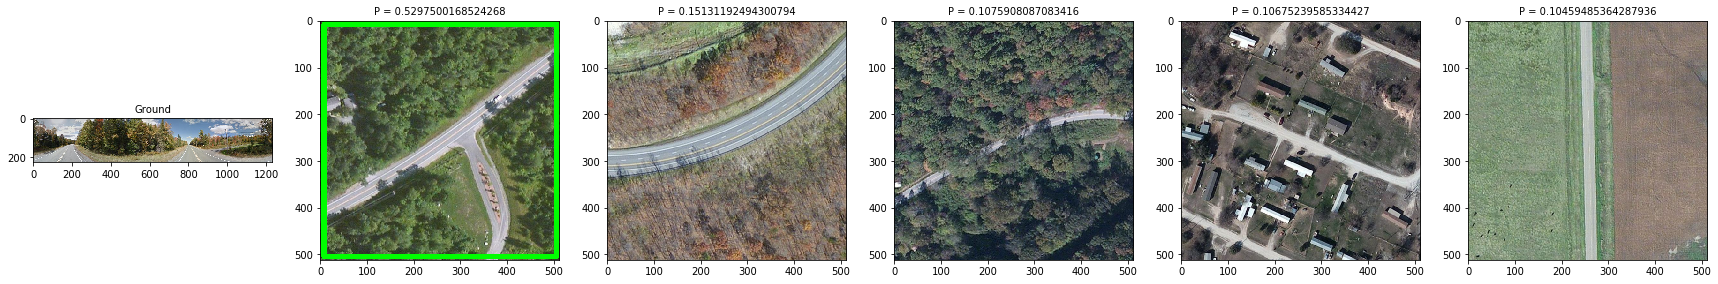

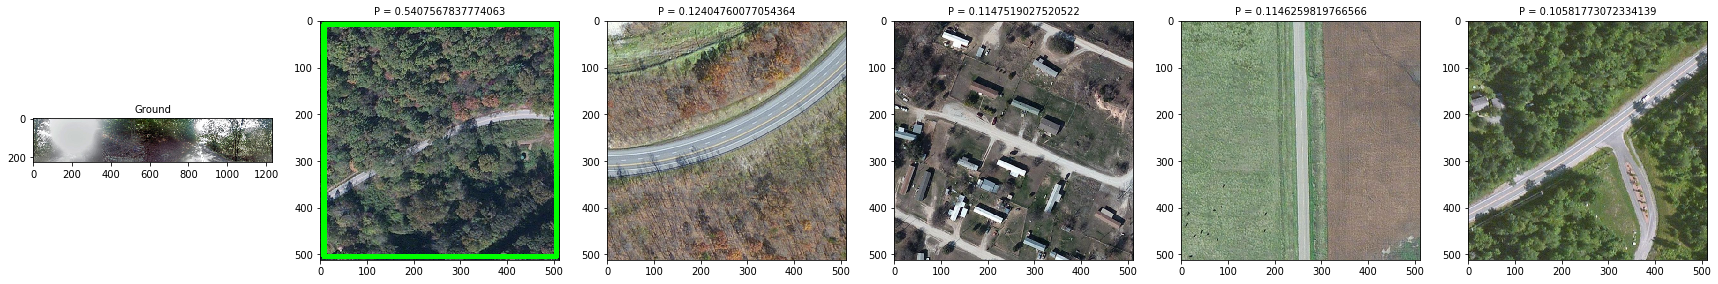

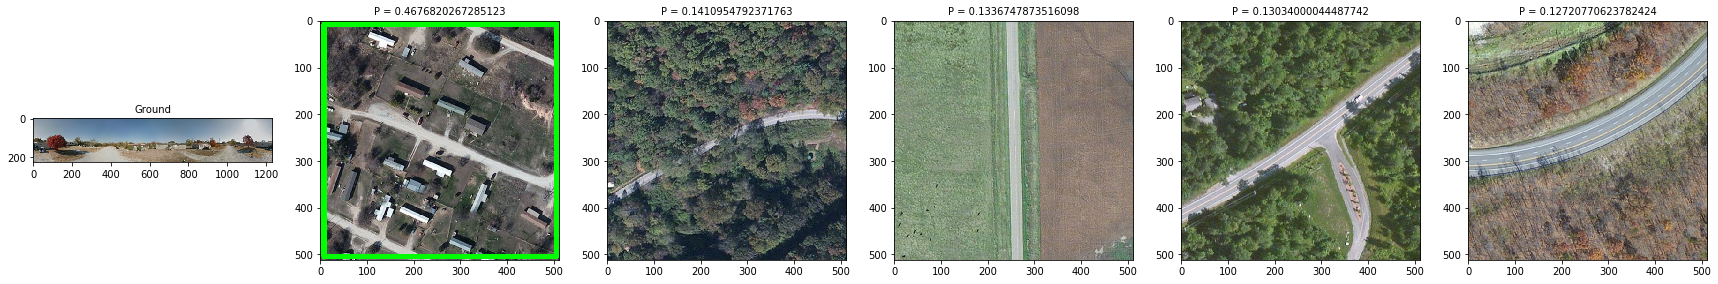

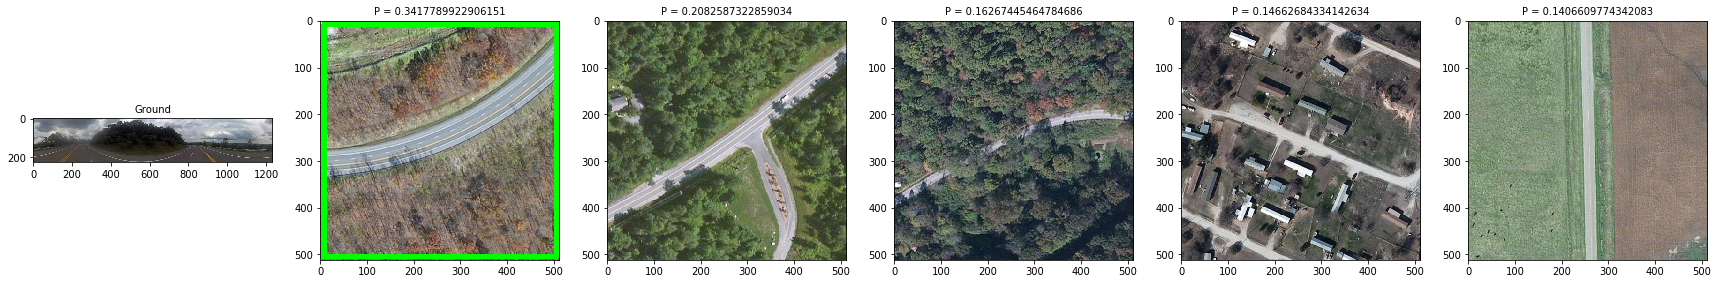

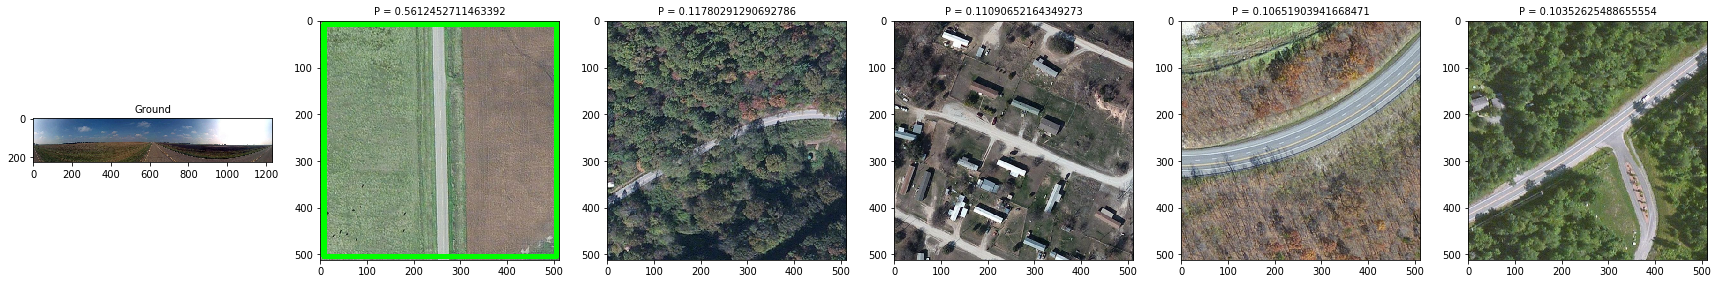

In [58]:
i = 0
for euclidian_dist in euclidean_distances_list:
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(30,10))
    ax1.imshow(ground_images[i])
    ax1.set_title('Ground', fontsize=10)
    ax2.imshow(add_frame(satellite_images[euclidian_dist[0][0]], i == euclidian_dist[0][0]))
    ax2.set_title('P = ' + str(euclidian_dist[0][1]), fontsize=10)
    ax3.imshow(add_frame(satellite_images[euclidian_dist[1][0]], i == euclidian_dist[1][0]))
    ax3.set_title('P = ' + str(euclidian_dist[1][1]), fontsize=10)
    ax4.imshow(add_frame(satellite_images[euclidian_dist[2][0]], i == euclidian_dist[2][0]))
    ax4.set_title('P = ' + str(euclidian_dist[2][1]), fontsize=10)
    ax5.imshow(add_frame(satellite_images[euclidian_dist[3][0]], i == euclidian_dist[3][0]))
    ax5.set_title('P = ' + str(euclidian_dist[3][1]), fontsize=10)
    ax6.imshow(add_frame(satellite_images[euclidian_dist[4][0]], i == euclidian_dist[4][0]))
    ax6.set_title('P = ' + str(euclidian_dist[4][1]), fontsize=10)
    plt.show()
    i += 1